<a href="https://colab.research.google.com/github/ShreshthSaxena/Algorithmic-Trading/blob/master/Algo_trading%20EMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import matplotlib.pyplot as plt
import math, time
import tensorflow as tf

Using TensorFlow backend.


In [0]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

def get(tickers, startdate, enddate):
  def data(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map (data, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG']
all_data = get(tickers, datetime.datetime(2012, 10, 1), datetime.datetime(2018, 1, 1))

all_data.head()

High        Low       Open      Close       Volume  \
Ticker Date                                                                  
AAPL   2012-10-01  96.678574  93.785713  95.879997  94.198570  135898700.0   
       2012-10-02  95.192856  92.949997  94.544289  94.472855  156998100.0   
       2012-10-03  95.980003  94.661430  94.980003  95.921425  106070300.0   
       2012-10-04  96.321426  95.078575  95.892860  95.257141   92681400.0   
       2012-10-05  95.142860  93.040001  95.028572  93.227142  148501500.0   

                   Adj Close  
Ticker Date                   
AAPL   2012-10-01  64.749588  
       2012-10-02  64.938141  
       2012-10-03  65.933838  
       2012-10-04  65.477219  
       2012-10-05  64.081856

In [0]:
aapl = all_data.loc['AAPL']

In [0]:
df= aapl.drop(['Close'],1)
print(df.shape)
df.tail()

(1321, 5)


,High,Low,Open,Volume,Adj Close
Date,,,,,
2017-12-22,175.419998,174.500000,174.679993,16114600.0,171.685074
2017-12-26,171.470001,169.679993,170.800003,33185500.0,167.329453
2017-12-27,170.779999,169.710007,170.100006,21498200.0,167.358871
2017-12-28,171.850006,170.479996,171.000000,16480200.0,167.829758
2017-12-29,170.589996,169.220001,170.520004,25884400.0,166.014908


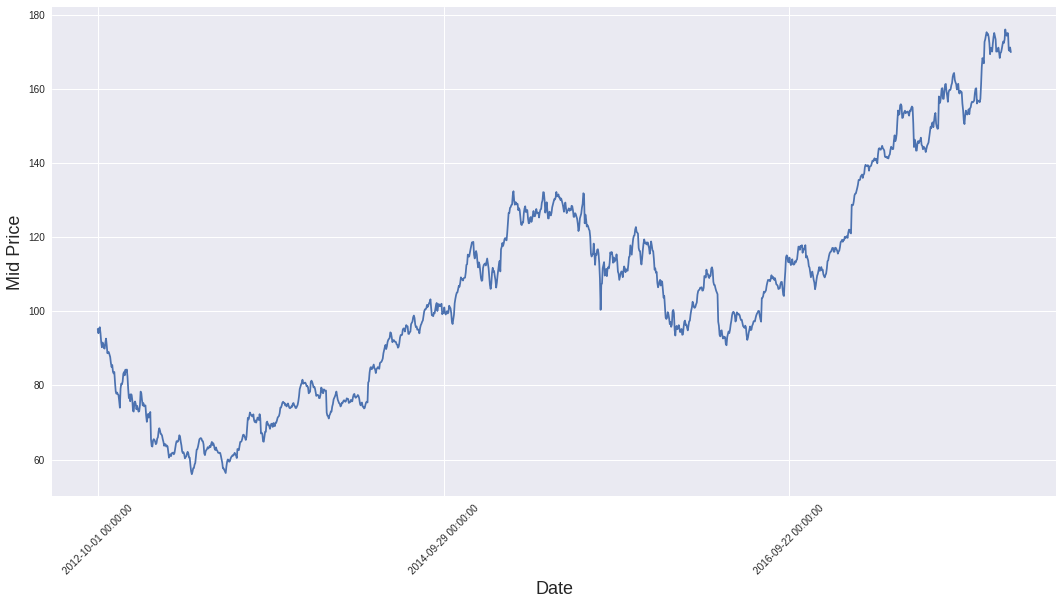

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df.index[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [0]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

def normalize_data(df):
  smoothing_window_size = 500
  for di in range(0,1321,smoothing_window_size):
      if di +  smoothing_window_size > df.shape[0]:
        dil  = df.shape[0]
      else:
        dil = di+smoothing_window_size
      df['Open'][di:dil] = np.squeeze(scaler.fit_transform(df.Open.values.reshape(-1,1)[di:dil]))
      df['High'][di:dil] = np.squeeze(scaler.fit_transform(df.High.values.reshape(-1,1)[di:dil]))
      df['Low'][di:dil] = np.squeeze(scaler.fit_transform(df.Low.values.reshape(-1,1)[di:dil]))
      df['Volume'][di:dil] = np.squeeze(scaler.fit_transform(df.Volume.values.reshape(-1,1)[di:dil]))
      df['Adj Close'][di:dil] = np.squeeze(scaler.fit_transform(df['Adj Close'].values.reshape(-1,1)[di:dil]))
  return df
    
df = normalize_data(df)
df.tail()


,High,Low,Open,Volume,Adj Close
Date,,,,,
2017-12-22,0.974396,0.994914,0.993726,0.046152,0.980520
2017-12-26,0.917578,0.926815,0.937117,0.215996,0.919180
2017-12-27,0.907652,0.927239,0.926904,0.099715,0.919595
2017-12-28,0.923044,0.938118,0.940035,0.049790,0.926226
2017-12-29,0.904919,0.920316,0.933032,0.143355,0.900668


In [0]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [0]:
window = 22

In [0]:

X_train, y_train, X_test, y_test = load_data(df, window)
X_train.shape

(1168, 22, 5)

In [0]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    
    #model.add(Flatten())   
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
    
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [0]:
model = build_model([5,window,1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Compilation Time :  0.03403162956237793


In [0]:
model.fit(X_train,y_train,batch_size=512,epochs=100,validation_split=0.1,verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 1051 samples, validate on 117 samples
Epoch 1/100
 - 4s - loss: 0.2525 - acc: 0.0029 - val_loss: 0.2031 - val_acc: 0.0000e+00
Epoch 2/100
 - 0s - loss: 0.1823 - acc: 0.0029 - val_loss: 0.0139 - val_acc: 0.0000e+00
Epoch 3/100
 - 0s - loss: 0.0657 - acc: 0.0029 - val_loss: 0.0256 - val_acc: 0.0000e+00
Epoch 4/100
 - 0s - loss: 0.0767 - acc: 0.0038 - val_loss: 0.0196 - val_acc: 0.0000e+00
Epoch 5/100
 - 0s - loss: 0.0614 - acc: 0.0029 - val_loss: 0.0410 - val_acc: 0.0000e+00
Epoch 6/100
 - 0s - loss: 0.0684 - acc: 0.0029 - val_loss: 0.0259 - val_acc: 0.0000e+00
Epoch 7/100
 - 0s - loss: 0.0496 - acc: 0.0038 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 8/100
 - 0s - loss: 0.0389 - acc: 0.0048 - val_loss: 0.0070 - val_acc: 0.0000e+00
Epoch 9/100
 - 0s - loss: 0.0246 - acc: 0.0048 - val_loss: 0.0313 - val_acc: 0.0000e+00
Epoch 10/100
 - 0s - loss: 0.0316 - acc: 0.0048 - val_loss: 0.0136 - val_acc: 0.0000e+00
Epoch 11/100
 - 0s - los

In [0]:
p = model.predict(X_test)

In [0]:
newp =  p
newy_test =  y_test

In [0]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00357 MSE (0.06 RMSE)
Test Score: 0.00201 MSE (0.04 RMSE)


(0.003574557281067365, 0.0020114836730779364)

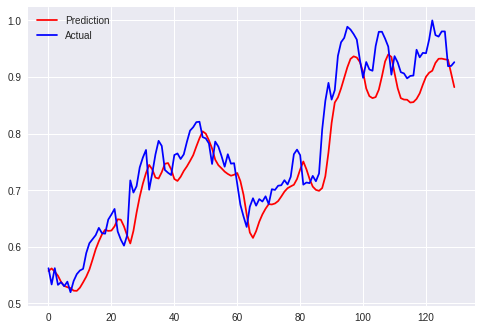

In [0]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

In [0]:
d=all_data[['Close']].reset_index().pivot('Date', 'Ticker', 'Close')
d

Ticker,AAPL,GOOG,IBM,MSFT
Date,,,,
2012-10-01,94.198570,378.428680,210.470001,29.490000
2012-10-02,94.472855,376.049164,209.839996,29.660000
2012-10-03,95.921425,378.786346,210.509995,29.860001
2012-10-04,95.257141,381.543427,210.389999,30.030001
2012-10-05,93.227142,381.344727,210.589996,29.850000
2012-10-08,91.167145,376.471405,209.820007,29.780001
2012-10-09,90.835716,369.640839,207.990005,29.280001
2012-10-10,91.558571,369.874329,205.820007,28.980000
2012-10-11,89.728569,373.311951,205.759995,28.950001


In [0]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=d.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = d['AAPL'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = d['AAPL'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

In [0]:
# Initialize the short and long windows
short_window = 25
long_window = 25

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=d.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = d['AAPL'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = d['AAPL'].ewm(span= long_window, min_periods = 1, adjust=False).mean()

# Create signals
#signalsn['signaln'][short_windown:] = np.where(signalsn['short_mavgn'][short_windown:] > signalsn['long_mavgn'][short_windown:], 1.0, 0.0) 
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] < signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

In [0]:
# Initialize the short and long windows
short_window = 25
long_window = 95

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=d.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = d['AAPL'].ewm(span= short_window, min_periods = 1, adjust=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = d['AAPL'].ewm(span= long_window, min_periods = 1, adjust=False).mean()

# Create signals
#signalsn['signaln'][short_windown:] = np.where(signalsn['short_mavgn'][short_windown:] > signalsn['long_mavgn'][short_windown:], 1.0, 0.0) 
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

In [0]:
signals.shape

(1321, 4)

In [0]:
signals.index

DatetimeIndex(['2012-10-01', '2012-10-02', '2012-10-03', '2012-10-04',
               '2012-10-05', '2012-10-08', '2012-10-09', '2012-10-10',
               '2012-10-11', '2012-10-12',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=1321, freq=None)

In [0]:
signals.columns

Index(['signal', 'short_mavg', 'long_mavg', 'positions'], dtype='object')

In [0]:
signals['signal'][short_window:]

Date
2012-11-07    0.0
2012-11-08    0.0
2012-11-09    0.0
2012-11-12    0.0
2012-11-13    0.0
2012-11-14    0.0
2012-11-15    0.0
2012-11-16    0.0
2012-11-19    0.0
2012-11-20    0.0
2012-11-21    0.0
2012-11-23    0.0
2012-11-26    0.0
2012-11-27    0.0
2012-11-28    0.0
2012-11-29    0.0
2012-11-30    0.0
2012-12-03    0.0
2012-12-04    0.0
2012-12-05    0.0
2012-12-06    0.0
2012-12-07    0.0
2012-12-10    0.0
2012-12-11    0.0
2012-12-12    0.0
2012-12-13    0.0
2012-12-14    0.0
2012-12-17    0.0
2012-12-18    0.0
2012-12-19    0.0
             ... 
2017-11-16    1.0
2017-11-17    1.0
2017-11-20    1.0
2017-11-21    1.0
2017-11-22    1.0
2017-11-24    1.0
2017-11-27    1.0
2017-11-28    1.0
2017-11-29    1.0
2017-11-30    1.0
2017-12-01    1.0
2017-12-04    1.0
2017-12-05    1.0
2017-12-06    1.0
2017-12-07    1.0
2017-12-08    1.0
2017-12-11    1.0
2017-12-12    1.0
2017-12-13    1.0
2017-12-14    1.0
2017-12-15    1.0
2017-12-18    1.0
2017-12-19    1.0
2017-12-20    1.0
2017-

In [0]:
np.where(signals['short_mavg'][short_window:] < signals['long_mavg'][short_window:], 1.0, 0.0)

array([1., 1., 1., ..., 0., 0., 0.])

In [0]:
signals.loc[signals.positions == 1.0]

,signal,short_mavg,long_mavg,positions
Date,,,,
2013-08-08,1.0,63.459310,63.360292,1.0
2015-11-09,1.0,117.170625,117.058122,1.0
2015-11-25,1.0,117.024368,116.970050,1.0
2016-04-04,1.0,104.998656,104.916392,1.0
2016-08-02,1.0,99.794730,99.643741,1.0


In [0]:
signals.short_mavg[signals.positions == 1.0]

Date
2013-08-08     63.459310
2015-11-09    117.170625
2015-11-25    117.024368
2016-04-04    104.998656
2016-08-02     99.794730
Name: short_mavg, dtype: float64

In [0]:
short_mavg = d.ewm(span= long_window, min_periods = 1, adjust=False).mean()
long_mavg = d.ewm(span= long_window, min_periods = 1, adjust=False).mean()

signals1 = pd.DataFrame(index=d.index)
signals1['signal_AAPL'] = 0.0
#signals1['signal_AAPL'][short_window:] = np.where(short_mavg['AAPL'][short_window:] > long_mavg['AAPL'][short_window:], 1.0, 0.0)
signals1['signal_AAPL'][short_window:] = np.where(short_mavg['AAPL'][short_window:] 
                                            > long_mavg['AAPL'][short_window:], 1.0, 0.0)

signals1['positions_AAPL'] = signals1['signal_AAPL'].diff()


In [0]:
signals1

,signal_AAPL,positions_AAPL
Date,,
2012-10-01,0.0,NaN
2012-10-02,0.0,0.0
2012-10-03,0.0,0.0
2012-10-04,0.0,0.0
2012-10-05,0.0,0.0
2012-10-08,0.0,0.0
2012-10-09,0.0,0.0
2012-10-10,0.0,0.0
2012-10-11,0.0,0.0


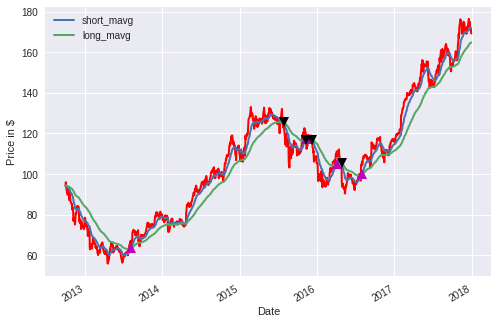

In [0]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
d['AAPL'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [0]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')['AAPL'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')['AAPL'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')['AAPL'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

In [0]:
portfolio

,AAPL,holdings,cash,total,returns
Date,,,,,
2012-10-01,0.000000,0.000000,100000.000000,100000.000000,NaN
2012-10-02,0.000000,0.000000,100000.000000,100000.000000,0.000000
2012-10-03,0.000000,0.000000,100000.000000,100000.000000,0.000000
2012-10-04,0.000000,0.000000,100000.000000,100000.000000,0.000000
2012-10-05,0.000000,0.000000,100000.000000,100000.000000,0.000000
2012-10-08,0.000000,0.000000,100000.000000,100000.000000,0.000000
2012-10-09,0.000000,0.000000,100000.000000,100000.000000,0.000000
2012-10-10,0.000000,0.000000,100000.000000,100000.000000,0.000000
2012-10-11,0.000000,0.000000,100000.000000,100000.000000,0.000000


In [0]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

1.0757357252932698
